# Videos

In [1]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
import matplotlib
import src.utils as utils

Folders

In [2]:
experiment = '180919_MDN_CsCh_Fly6_001_SG1_behData_images'
root_folder = '/data/LiftFly3D/DF3D/data_DF3D/'
dims_to_consider = [i for i in range(38) if i not in [15,16,17,18,34,35,36,37]] 

Plot 2D stacked hourglass prediction on images and save as a 25fps video (4x slower)

In [3]:
G, color_edge = skeleton()
poses = pickle.load(open(root_folder + 'pose_result__data_paper_' + experiment + '.pkl', "rb"))
poses = poses['points2d']
poses = poses[:,:,dims_to_consider,:]
poses.shape

(7, 900, 30, 2)

/data/LiftFly3D/DF3D/data_DF3D/180919_MDN_CsCh_Fly6_001_SG1_behData_images/camera_5*.jpg


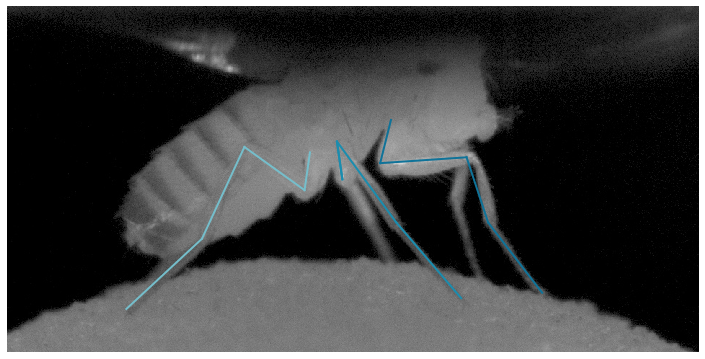

In [31]:
cam=5 #5 #run twice for cam 1 and 5

#load images
files = glob.glob(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')
imgs = []
for f in sorted(files):
    img = cv2.imread(f)
    if cam == 5:
        img = np.fliplr(img)
    imgs.append(img)
    
assert imgs != [], 'no files found'    

#filter
poses2d = poses[cam,:,:,:]
poses2d = np.reshape(poses2d, (poses2d.shape[0], poses2d.shape[1]*poses2d.shape[2]))
poses2d = utils.filter_data({'data': poses2d}, window=5, order=2)['data']

fig = plt.figure(figsize=(9.6,4.8))
print(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')

writer = FFMpegWriter(fps=25)
with writer.saving(fig, root_folder + "/camera_" + str(cam) + ".mp4", 100):
    for t in range(poses.shape[1]):
        plt.cla()
        
        plt.imshow(imgs[t])
        
        for i, j in enumerate(G.edges()): 
            x = np.array((poses2d[t,2*j[0]], poses2d[t,2*j[1]]))
            y = np.array((poses2d[t,2*j[0]+1], poses2d[t,2*j[1]+1]))
                   
            plt.plot(x, y, c=color_edge[i], alpha=1.0, linewidth = 2)
            if (t >= 100) & (t<800):
                if cam==5:
                    plt.scatter(60,50, marker = "o", c='b', s = 500)
                else:
                    plt.scatter(900,50, marker = "o", c='b', s = 500)
            
        plt.axis('off')
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        
        writer.grab_frame()

Merge videos

In [ ]:
#to create video_1.mp4, execute these commands in sequence in the folder where the videos are

#flip camera5 horizontally 
#ffmpeg -i camera_5.mp4 -vf hflip -c:a copy camera_5flipped.mp4

#stack videos vertically (call this in the folder where the images are)
#ffmpeg -i camera_1.mp4 -i camera_5flipped.mp4 -filter_complex vstack=inputs=2 stacked.mp4

#annotate
#ffmpeg -i stacked.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/src/helvetica.ttf: text='Camera 2': fontcolor=white: fontsize=80: x=1*(w-text_w)/10: y=1*(h-text_h)/10/2" -codec:a copy stacked_b.mp4
#ffmpeg -i stacked_b.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/src/helvetica.ttf: text='Camera 5': fontcolor=white: fontsize=80: x=1*(w-text_w)/10: y=6*(h-text_h)/10" -codec:a copy stacked_2b.mp4

#stack videos horizontally (call this in the folder where the images are)
#ffmpeg -i stacked_2b.mp4 -i prediction_cams.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output.mp4
